My edits are marked with **, my only edits are improving the plots and a question at the end. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geoviews as gv
import hvplot.xarray
import cartopy.crs as ccrs
import cmocean.cm as cmo
import cartopy

In [9]:
from dask.distributed import Client
client = Client()

/home/dylan/.local/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37995 instead
  http_address["port"], self.http_server.port


## Datasets

- NAM-ANL,Historical data
Atmospheric data analysis for Copano Bay:
[link](https://www.ncei.noaa.gov/thredds/catalog/model-namanl-old/catalog.html)                                       

In order to check the data, one-day data was imported from NOAA.
This approach will be applied to analyze Copano Bay project.

In [6]:
url = ['https://www.ncei.noaa.gov/thredds/dodsC/model-namanl-old/201507/20150729/namanl_218_20150729_0000_000.grb'
       ,'https://www.ncei.noaa.gov/thredds/dodsC/model-namanl-old/201507/20150729/namanl_218_20150729_0600_000.grb'
       ,'https://www.ncei.noaa.gov/thredds/dodsC/model-namanl-old/201507/20150729/namanl_218_20150729_1200_000.grb'
       ,'https://www.ncei.noaa.gov/thredds/dodsC/model-namanl-old/201507/20150729/namanl_218_20150729_1800_000.grb'
       ]
ds = xr.open_mfdataset(url, 
        compat="override",
        combine="by_coords",
        data_vars="minimal",
        coords="minimal")

- The code below was quoted from Dr. Hetland's classnote.

In [7]:
proj = ccrs.LambertConformal(central_longitude=265,
                             central_latitude=25.0,
                             standard_parallels=[25.0]
                            )

x, y = np.meshgrid(ds.x, ds.y)
llz = ccrs.PlateCarree().transform_points(proj, 1000*x, 1000*y)
lon = llz[:, :, 0]
lat = llz[:, :, 1]

ds['lon'] = xr.DataArray(lon, dims=['y', 'x']).chunk(*lon.shape)
ds['lat'] = xr.DataArray(lat, dims=['y', 'x']).chunk(*lat.shape)

ds.coords['lon'] = ds.lon
ds.coords['lat'] = ds.lat

ds = ds.unify_chunks()

- Surface Temperature & Precipitation
From the dataset, there both data only exists at 2015-07-29-12T 12:00(time=2).

** These plots are okay - but I think you can clean them up with cartopy

Text(0.5, 1.0, 'Surface Temperature')

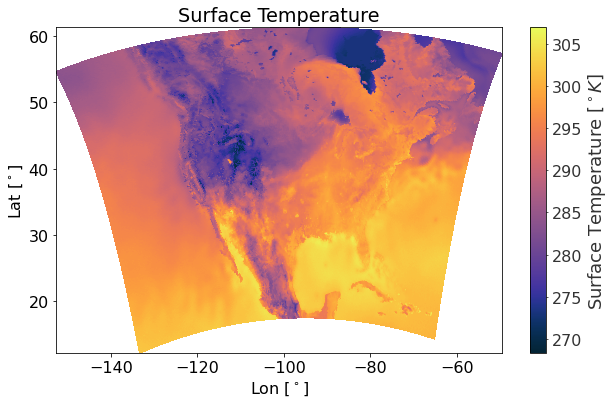

In [46]:
#Surface Temperature
plt.rcParams.update({'font.size': 16})

T_surf=ds.Temperature_surface.isel(time = 2)

fig, ax = plt.subplots(1, figsize = (10,6))

mappable = ax.pcolormesh(T_surf.lon.values,
                         T_surf.lat.values,
                         T_surf.values,
                         cmap = cmo.thermal)
ax.set_xlabel('Lon [$^\circ$]')
ax.set_ylabel('Lat [$^\circ$]')

cax = fig.add_axes() 
cb = fig.colorbar(mappable, cax=cax, orientation='vertical')
cb.set_label(r'Surface Temperature [$^\circ K$]', fontsize=18, color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

ax.set_title('Surface Temperature')

Text(0.5, 1.0, 'Precipitation')

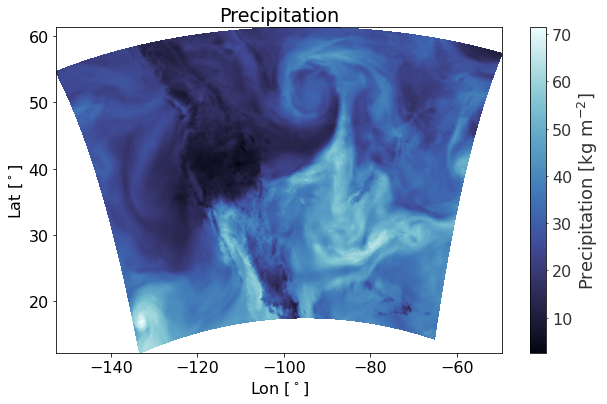

In [44]:
#precipitation
prec=ds.Precipitable_water_entire_atmosphere.isel(time = 2)

fig, ax = plt.subplots(1, figsize = (10,6))

mappable = ax.pcolormesh(prec.lon.values,
                         prec.lat.values,
                         prec.values,
                         cmap = cmo.ice)
ax.set_xlabel('Lon [$^\circ$]')
ax.set_ylabel('Lat [$^\circ$]')

cax = fig.add_axes() 
cb = fig.colorbar(mappable, cax=cax, orientation='vertical')
cb.set_label(r'Precipitation [kg m$^{-2}$]', fontsize=18, color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

ax.set_title('Precipitation')

## Copano Bay
- The domain for Copano Bay is defined as 28.03N<Latitude<28.20N and -97.20W<Longitude<-96.99W 
- There are four cells for the entire Copano Bay, since the grid size is 12km.
- Surface temperature data will not be suitable.
- Precipitation, wind data could be considered.

** One thing I'd like to see is you show a picture of where copano is, which I'll do below.

In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

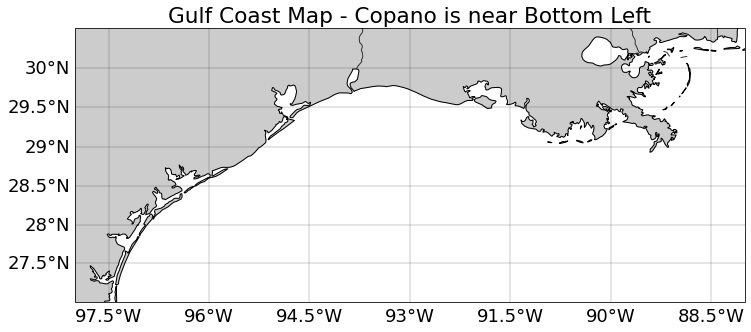

In [52]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))


land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-94, -91.5, 28.3, 29.6], ccrs.PlateCarree())
ax.set_extent([-98, -88, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_title('Gulf Coast Map - Copano is near Bottom Left')

plt.rcParams.update({'font.size': 18})

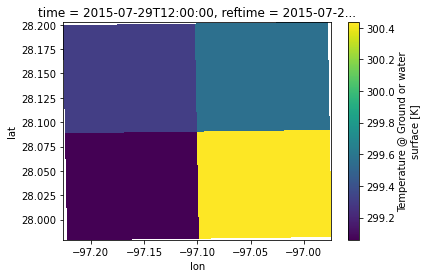

In [12]:
#Surface temperature @ Copano Bay
section1 = T_surf.isel(time=2)
foo1 = section1.where( (ds.lat > 28.03) & (ds.lat < 28.2) & (ds.lon > -97.2) & (ds.lon < -96.99), drop=True)
foo1.plot(x='lon', y='lat')

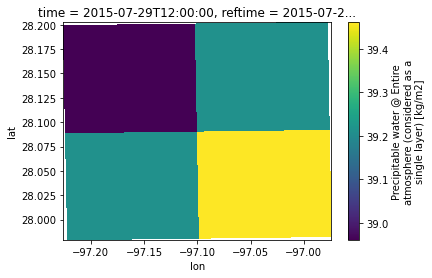

In [14]:
#Precipitation @ Copano Bay
section2 = precipitation.isel(time=2)
foo2 = section2.where( (ds.lat > 28.03) & (ds.lat < 28.2) & (ds.lon > -97.2) & (ds.lon < -96.99), drop=True)
foo2.plot(x='lon', y='lat')

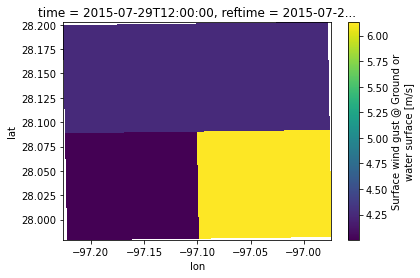

In [15]:
#Surface wind gust @ Copano Bay
#Surface wind gust
wg_surf=ds.Surface_wind_gust_surface
section3 = wg_surf.isel(time=2)
foo3 = section3.where( (ds.lat > 28.03) & (ds.lat < 28.2) & (ds.lon > -97.2) & (ds.lon < -96.99), drop=True)
foo3.plot(x='lon', y='lat')

## Future work
- Add datasets from 2010 to 2015
- Decide whether using NAM model or real measurement data at a station

** This code is fine so far. One question I have is there higher resolution atmospheric data available for Copano? 4 grid cells seems a bit low. 